## Math110A 45009 HW4 code
<p>Name: Anhong Yang</p>
<p>UCIID: 41845042</p>
<p>Date: 2022/3/12</p>

In [1]:
import numpy as np  # arrays
import matplotlib.pyplot as plt  # 2d plotting
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Question 1

In [2]:
def QObjFunc(x): # f
    return (100*(x[1]-x[0]**2)**2+(1-x[0])**2)
def QGradObjFunc(x): # gradient of f
    return np.array([-400*x[0]*x[1]+400*x[0]**3+2*x[0]-2,200*(x[1]-x[0]**2)])

In [3]:
def heavyBall(objFunc, gradObjFunc, x0, tol, maxIter):
    path = [x0]
    k = 0
    xk = x0 
    pk = -gradObjFunc(xk)
    # Compute the first step separately. 
    if norm(pk) < tol:
        return xk, 0, path
    else:
        k = k + 1
        xk = xk + alpha * pk 
        path.append(xk)
# The rest of iterations
    pk = -gradObjFunc(xk)

    while norm(pk) > tol and k <= maxIter: 
    # use path[-2] since path[-1] is the xk
        xk = xk + alpha * pk + beta * (xk - path[-2])
        pk = -gradObjFunc(xk)
        k = k + 1
        path.append(xk)
    path = np.array(path) # convert to array
    if norm(pk) <= tol:
        print("Found the minimizer at {x} with {iter} iterations successfully, gradient's norm is {nrm}.".format(x=xk,iter=k,nrm=norm(pk)))
    else:
        print("Unable to locate minimizer within maximum iterations, last position is at {x}, gradient's norm is {nrm}".format(x=xk,nrm=norm(pk)))
    return xk, k, path

In [4]:
d2f= lambda x,y: np.array([[-400*y+2+1200*x**2,-400*x],[-400*x,200]])

In [5]:
eigs, _ = np.linalg.eigh(d2f(1,1))
print(eigs)
print('alpha = ',4/(np.sqrt(eigs[0])+np.sqrt(eigs[1]))**2)
print('beta = ',(np.sqrt(eigs[1])-np.sqrt(eigs[0]))**2/(np.sqrt(eigs[1])+np.sqrt(eigs[0]))**2)

[3.99360767e-01 1.00160064e+03]
alpha =  0.0038387715930902127
beta =  0.9232245681381966


In [6]:
x0 = np.array([1.2, 1.2]) # Harder to converge
tol = 1e-8
maxIter = 1e6 
alpha=4/(np.sqrt(eigs[0])+np.sqrt(eigs[1]))**2
beta=(np.sqrt(eigs[1])-np.sqrt(eigs[0]))**2/(np.sqrt(eigs[1])+np.sqrt(eigs[0]))**2
x_1, iter_1, path_1 = heavyBall(QObjFunc, QGradObjFunc,x0, tol, maxIter)

Unable to locate minimizer within maximum iterations, last position is at [           -inf 2.74356425e+265], gradient's norm is nan


<ipython-input-2-6dc107c5363b>:4: RuntimeWarning: overflow encountered in double_scalars
  return np.array([-400*x[0]*x[1]+400*x[0]**3+2*x[0]-2,200*(x[1]-x[0]**2)])
<ipython-input-2-6dc107c5363b>:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([-400*x[0]*x[1]+400*x[0]**3+2*x[0]-2,200*(x[1]-x[0]**2)])


The optimize alpha and beta might cause some error, so we choose the near alpha and beta instead.

In [7]:
alpha=0.0035
beta=0.924
x_1, iter_1, path_1 = heavyBall(QObjFunc, QGradObjFunc,x0, tol, maxIter)

Found the minimizer at [0.99999999 0.99999998] with 667 iterations successfully, gradient's norm is 9.97342675772787e-09.


Text(0.5, 1.0, 'the norm of gradient on log scale vs. iteration numbers')

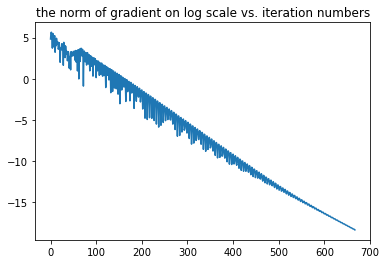

In [8]:
Npath=[]
for i in range(len(path_1)):
    Npath.append(np.linalg.norm(QGradObjFunc(path_1[i])))
plt.plot(np.log(Npath))
plt.title("the norm of gradient on log scale vs. iteration numbers")

## Question 2 Linear

In [9]:
data = np.loadtxt("CaCovidInfMarch24toMidJuly.txt").reshape(-1,1)
Xcovid = np.arange(1, len(data) + 1).reshape(-1,1)

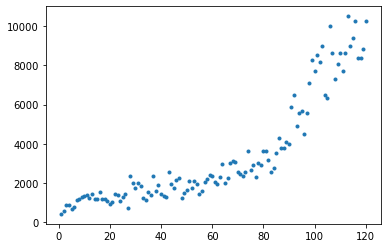

In [10]:
plt.plot(Xcovid,data,".")

### a) normal line

In [11]:
#training data
x_t=Xcovid[0:90]
y_t=data[0:90]
#validation data
x_val=Xcovid[90:120]
model = LinearRegression()
model.fit(x_t, y_t) 
model.intercept_, model.coef_

(array([613.31244327]), array([[30.17059661]]))

### b) full batch gradient descent;

In [12]:
def gradient_descent(X_b, y, X, n_iterations,sz, eta=4e-20):
    # n_iterations: total epochs
    # eta: fixed learning rate (step size)
    # X: for plotting purposes
    theta_path_bgd = []
    theta = np.random.randn(sz,1) #random start
    for iteration in range(n_iterations):
        gradients = X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        theta_path_bgd.append(theta)
    return theta_path_bgd, theta

In [13]:
X_b1 = np.c_[np.ones((90, 1)), x_t] # add x0 = 1 to each instance

In [14]:
theta_path_bgd1, theta1= gradient_descent(X_b1, y_t, Xcovid,300000,sz=2)
theta1

array([[0.5282682 ],
       [1.52500252]])

### c) mini-batch (size 10) stochastic gradient descent

In [15]:
def minibatch_gradient_descent(X_b, y, n_iterations, minibatch_size, t0=200, t1=500):
    theta_path_mgd = []
    np.random.seed(42)
    m = len(X_b)
    theta = np.random.randn(2,1) # random initialization
    def learning_schedule(t): # Learning rate
        return t0 / (t + t1)
    t = 0
    for epoch in range(n_iterations):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X_b[shuffled_indices]
        # shuffle/randomize indices towards iid samples
        # to improve settling down towards convergence
        y_shuffled = y[shuffled_indices]
        for i in range(0, m, minibatch_size):
            t += 1
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(t)
            theta = theta - eta * gradients
            theta_path_mgd.append(theta)
    return theta_path_mgd

### d) compute training and prediction mean square errors

#### normal line

In [16]:
np.sqrt(mean_squared_error(data, model.predict(Xcovid)))

2162.0575098036675

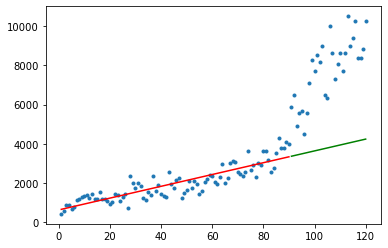

In [17]:
plt.plot(Xcovid,data,".")
plt.plot(x_t, model.predict(x_t), "r")
plt.plot(x_val, model.predict(x_val), "g")

#### full batch

In [18]:
np.sqrt(mean_squared_error(data,theta1[0] + theta1[1]*Xcovid))

4311.164814448133

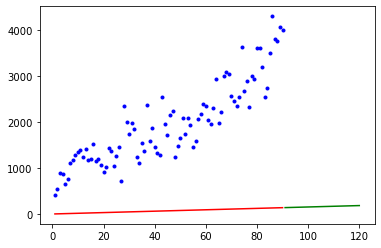

In [19]:
plt.plot(x_t, y_t, "b.")
plt.plot(x_t, theta1[0] + theta1[1]*x_t,"r")
plt.plot(x_val, theta1[0] + theta1[1]*x_val,"g")
plt.show()

## Q3 quadratic polynomial

### a) normal line

In [20]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(Xcovid)

In [21]:
x_t2=X_poly[0:90]
x_val2=X_poly[90:120]
model2= LinearRegression()
model2.fit(x_t2, y_t)
model2.intercept_, model2.coef_

(array([1001.09376488]), array([[4.88051042, 0.27791304]]))

### b) full batch

In [22]:
X_b2 = np.c_[np.ones((90, 1)), x_t2] # add x0 = 1 to each instance

In [23]:
theta_path_bgd2, theta2= gradient_descent(X_b2, y_t, Xcovid, 300000,sz=3,eta=4e-10)

In [24]:
print(theta2)

[[ 2.37492702e+00]
 [ 4.13164463e+01]
 [-2.21171166e-02]]


### d) compute training and prediction mean square errors

#### normal line

In [25]:
np.sqrt(mean_squared_error(data, model2.predict(X_poly)))

1741.6430953006652

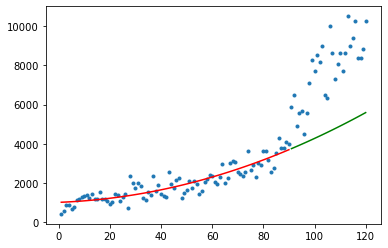

In [26]:
plt.plot(Xcovid,data,".")
plt.plot(x_t, model2.predict(x_t2), "r")
plt.plot(x_val, model2.predict(x_val2), "g")

#### full batch

In [37]:
np.sqrt(mean_squared_error(data,theta2[0] + theta2[1]*Xcovid+theta2[2]*Xcovid**2))

2025.2290818203676

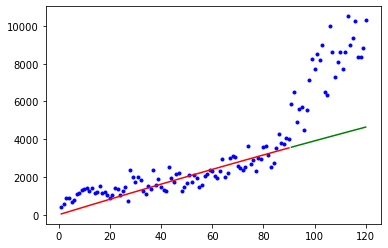

In [28]:
plt.plot(Xcovid, data, "b.")
FQ1=theta2[0] + theta2[1]*x_t+theta2[2]*x_t**2
FQ2=theta2[0] + theta2[1]*x_val+theta2[2]*x_val**2
plt.plot(x_t,FQ1,"r")
plt.plot(x_val,FQ2,"g")
plt.show()

## Q4 cubic polynomial

### a) normal line

In [29]:
poly_features2 = PolynomialFeatures(degree=3, include_bias=False)
X_poly2 = poly_features2.fit_transform(Xcovid)

In [30]:
x_t3=X_poly2[0:90]
x_val3=X_poly2[90:120]
model3= LinearRegression()
model3.fit(x_t3, y_t)
model3.intercept_, model3.coef_

(array([653.08781856]),
 array([[ 4.95422479e+01, -9.42304168e-01,  8.93932017e-03]]))

### b) full batch

In [31]:
X_b3 = np.c_[np.ones((90, 1)), x_t3] # add x0 = 1 to each instance

In [32]:
theta_path_bgd3, theta3= gradient_descent(X_b3, y_t, Xcovid, 30000,sz=4,eta=4e-15)
print(theta3)

[[ 0.71379727]
 [ 1.50792661]
 [-0.67964289]
 [ 0.01530532]]


### d) compute training and prediction mean square errors

#### normal line

In [33]:
np.sqrt(mean_squared_error(data, model3.predict(X_poly2)))

1086.3586813992365

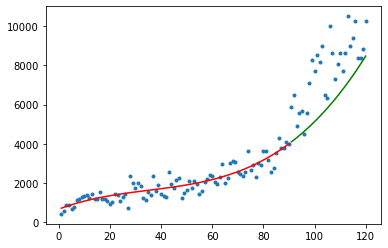

In [34]:
plt.plot(Xcovid,data,".")
plt.plot(x_t, model3.predict(x_t3), "r")
plt.plot(x_val, model3.predict(x_val3), "g")

#### full batch

In [40]:
np.sqrt(mean_squared_error(data,theta3[0]+theta3[1]*Xcovid+theta3[2]*Xcovid**2+theta3[3]*Xcovid**3))

2238.3965593072376

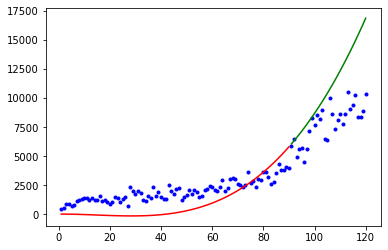

In [41]:
plt.plot(Xcovid, data, "b.")
FC1=theta2[0] + theta3[1]*x_t+theta3[2]*x_t**2+theta3[3]*x_t**3
FC2=theta2[0] + theta3[1]*x_val+theta3[2]*x_val**2+theta3[3]*x_val**3
plt.plot(x_t,FC1,"r")
plt.plot(x_val,FC2,"g")
plt.show()